In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

In [7]:
training_data = datasets.FashionMNIST(
	root='data',
	download=True,
	train=True,
	transform=ToTensor(),
	target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
)

testing_data = datasets.FashionMNIST(
	root='data',
	download=True,
	train=False,
	transform=ToTensor(),
	target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
)

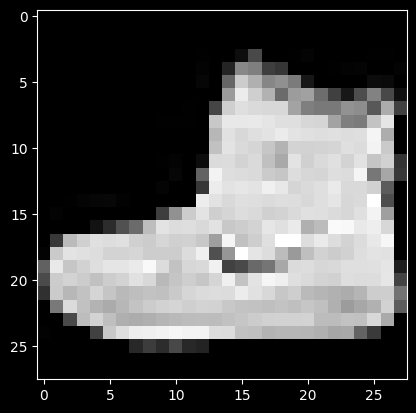

<Figure size 400x400 with 0 Axes>

In [8]:

img, label = training_data[0]
plt.imshow(img.squeeze(), cmap="gray")
plt.figure(figsize=(4,4))
plt.show()

In [9]:
class NeuralNetwork(nn.Module):
	def __init__(self):
		super(NeuralNetwork, self).__init__()
		self.flatten = nn.Flatten()
		self.linear_relu_stack = nn.Sequential(
			nn.Linear(28*28, 512),
			nn.ReLU(),
			nn.Linear(512, 512),
			nn.ReLU(),
			nn.Linear(512, 10),
		)

	def forward(self, x):
		x = self.flatten(x)
		logits = self.linear_relu_stack(x)
		return logits

In [10]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [11]:
BATCH_SIZE = 64

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE)



In [12]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to('cpu'), y.to('cpu')
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to('cpu'), y.to('cpu')
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
epochs = 10

# for t in range(epochs):
# 	print(f"Epochs: {t+1}\n ----------------------------------------")
# 	train_loop(train_dataloader, model, loss_fn, optimizer)
# 	test_loop(test_dataloader, model, loss_fn)
